# Genetic Programming - III


“It is not the strongest of the species that survives,
not the most intelligent that survives.
It is the one that is the most adaptable to change.”
― Charles Darwin 

# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





In [1]:
!pip install deap

In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [3]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [4]:
import random
import operator
import math
import numpy
import matplotlib.pyplot as plt

#GP
from deap import creator, base, gp, tools, algorithms
import networkx as nx
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

## Creating the process

Since we are experimenting virtually, we need to create a dynamical system representation, to test the effect of controller model on the process. 

THe problem we are interested in is a well mixed reactor, in which we utilize a cooling system with embedded heat exchangers. 

The process is complex despite the well-mixed assumption. We have:

* heat release with reaction increasing the T
* we have mass flow in and out
* we have reaction kinetics sensetive to the temperature
* First order reaction: rate ~ reactant (A) concentration ( A => B)

We can control coolant temperature to some extend and would like to keep the conversion rate stable, even when the process dynamics change.

In [5]:
'''
Problem definition: What could be a representative physical model? 
-----------------------------------------------------------------------
Continuous stirred-tank reactors have widespread application in industry and embody many features of
other types of reactors. CSTR models tend to be simpler than models for other types of continuous reactors
such as tubular reactors and packed-bed reactors. Consequently, a CSTR model provides a convenient way of
illustrating modeling principles for chemical reactors.

We will consider a simple liquid-phase, irreversible chemical reaction where chemical species A reacts to form
species B. Below you will see a list of parameters, defining the behaviour of our physical system.

For more details, refer to the lecture notes.

'''
#Parameters:
#-------------------------
q_0 = 100         #L/min
ER = 8750         #K
cA_i = 1          #mol/L
k0 = 7.2*(10**10)   #min-1
T_i = 350         #K
UA = 5*10**4      #J/min.K
V = 100           #L
Tc_0 = 300        #K
rho = 1000        #g/L
cA_0 = 0.5        #mol/L
cp = 0.239        #J/g.K
T_0 = 350         #K
deltaHr = -5*10**4  #J/mol
m_0 = q_0*rho
#-------------------------

# Pysical model:
#-------------------------

def niso_tank(x,t,Tc,m):
  # note that Tc and w are variables here
  cA = x[0]
  T = x[1]
  #Cons. of species:
  dcAdt = (m/rho)/V*(cA_i-cA)-k0*math.exp(-ER/T) * cA
  #Cons. of energy:
  dTdt = m/(V*rho)*(T_i-T) + (-deltaHr)/(rho*cp)*k0*math.exp(-ER/T)*cA + UA*(Tc-T)/(V*rho*cp)

  return [dcAdt,dTdt]


In [6]:
# Lets see the derivatives at the initial state:
print (niso_tank([cA_0,T_0],0,Tc_0,m_0))

[3.40208612952253e-05, -0.0071173349989948065]


In [7]:
# Process variables:
Tc = 305
m = m_0

In [8]:
# Checking the system dynamics:
# Here we will create three cases without control, to see the impact of Tc:
t = np.linspace(0,10,10000)
# odeint
x1 = odeint(niso_tank,[cA_0,T_0],t,args=(Tc,m))
x2 = odeint(niso_tank,[cA_0,T_0],t,args=(Tc+5,m))
x3 = odeint(niso_tank,[cA_0,T_0],t,args=(Tc-5,m))

In [9]:
# Plotting the results:
cA1 = x1[:,0]
T1 = x1[:,1]
cA2 = x2[:,0]
T2= x2[:,1]
cA3 = x3[:,0]
T3 = x3[:,1]

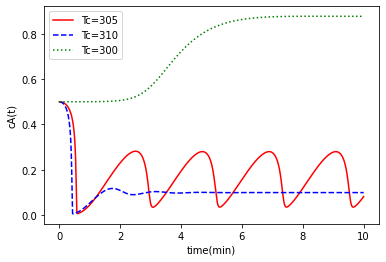

In [10]:
plt.plot(t,cA1,'r-',label='Tc=305')
plt.plot(t,cA2,'b--',label='Tc=310')
plt.plot(t,cA3,'g:',label='Tc=300')
plt.xlabel('time(min)')
plt.ylabel('cA(t)')
plt.legend()

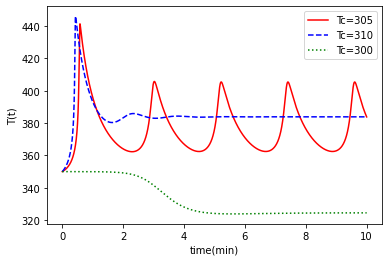

In [11]:
plt.plot(t,T1,'r-',label='Tc=305')
plt.plot(t,T2,'b--',label='Tc=310')
plt.plot(t,T3,'g:',label='Tc=300')
plt.xlabel('time(min)')
plt.ylabel('T(t)')
plt.legend()

### Mass flow rate effects

In [12]:
# Process variables: Now lets see what happens when the production rate decreases.
Tc = 305
m = m_0*0.9

In [13]:
# Checking the system dynamics:
t = np.linspace(0,100,10000)
# odeint
x1 = odeint(niso_tank,[cA_0,T_0],t,args=(Tc,m))
x2 = odeint(niso_tank,[cA_0,T_0],t,args=(Tc+20,m))
x3 = odeint(niso_tank,[cA_0,T_0],t,args=(Tc-20,m))

In [14]:
# Plotting the results:
cA1 = x1[:,0]
T1 = x1[:,1]
cA2 = x2[:,0]
T2= x2[:,1]
cA3 = x3[:,0]
T3 = x3[:,1]

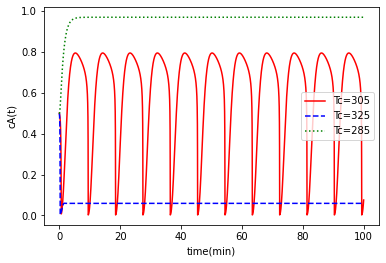

In [15]:
plt.plot(t,cA1,'r-',label='Tc=305')
plt.plot(t,cA2,'b--',label='Tc=325')
plt.plot(t,cA3,'g:',label='Tc=285')
plt.xlabel('time(min)')
plt.ylabel('cA(t)')
plt.legend()

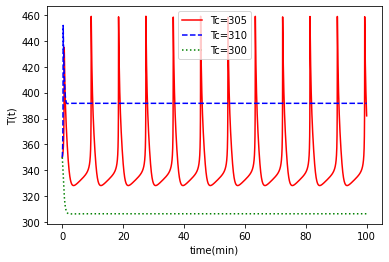

In [16]:
plt.plot(t,T1,'r-',label='Tc=305')
plt.plot(t,T2,'b--',label='Tc=310')
plt.plot(t,T3,'g:',label='Tc=300')
plt.xlabel('time(min)')
plt.ylabel('T(t)')
plt.legend()

# Problem definition


Going over the system dynamics, now we are ready to implement control over the system. Here is the confined problem:

* We have the same reactor as before,

* Manupulated variable is the coolant temperature

* We will adjust the Tc to satisfy the desired conversion levels, when system is disturbed/set point is changed.

* We will not predefine a controller function. It will be created via GP.

* We will use a math. model to hypothesize about the controller performance. It is a simpler representation of the pyhsical system.

* We will continously learn as new data become available. "Survival of the fittest" is applied in physical time. 

In [17]:
# Without control:
#--------------------------
t = np.linspace(0,10,10000)
Tc = 315
m = m_0*0.8
x = odeint(niso_tank,[cA_0,T_0],t,args=(Tc,m))

In [18]:
# Plotting the results:
cA = x[:,0]
T = x[:,1]

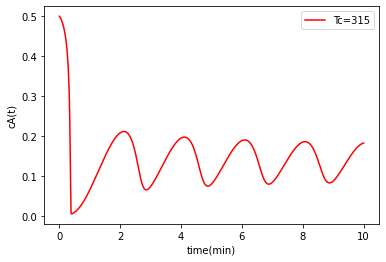

In [19]:
plt.plot(t,cA,'r-',label='Tc=315')
plt.xlabel('time(min)')
plt.ylabel('cA(t)')
plt.legend()

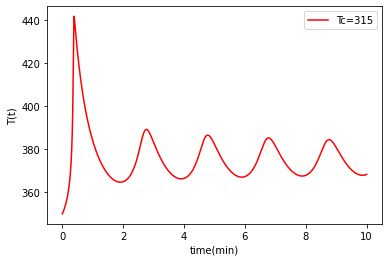

In [20]:
plt.plot(t,T,'r-',label='Tc=315')
plt.xlabel('time(min)')
plt.ylabel('T(t)')
plt.legend()

## Building the model

### Simulator

First step is to create a model for "model predictive control". This will allow our data-driven approach to hypothesize about the future and act accordingly. 

In [21]:
'''
Here we will use predictor model to run some initial estimates
for selecting best candidates to manupulate Tc.

* niso: nonisothermal tank model
* predictor: calls the niso to make predictions about the future.
'''
def niso_tank(x,t,Tc_test,m_t):
  # note that Tc and w are variables here
  cA_ = x[0]
  T_ = x[1]
  #Cons. of species:
  dcAdt = (m_t/rho)/V*(cA_i-cA_)-k0*np.exp(-ER/T_) * cA_
  #Cons. of energy:
  dTdt = m_t/(V*rho)*(T_i-T_) + (-deltaHr)/(rho*cp)*k0*np.exp(-ER/T_)*cA_ + UA*(Tc_test-T_)/(V*rho*cp)

  return [dcAdt,dTdt]

def predictor(Tc_test,cA_t, T_t):
  # Collecting data for the next minute:
  t = np.linspace(0,0.01,10)
  x = odeint(niso_tank,[cA_t,T_t],t,args=(Tc_test,m))
  return x

In [22]:
'''
In real life, we would have additional disturbances. Assume it comes from
  * hex operations => UA
  * m can not be perfect as well => m

  ! Note that we do not have a source for the data hence we approximate it with
    a noisy model. We could also have an experimental setup to feed data. 
'''
def exp_tank(x,t,Tc_test,m_t):
  # note that Tc and w can be variables here
  cA_ = x[0]
  T_ = x[1]
  m_t = m_t *(1+ np.random.normal(0,0.001))
  UA_prime = UA *(1+ np.random.normal(0,0.001))
  #Cons. of species:
  dcAdt = (m_t/rho)/V*(cA_i-cA_)-k0*np.exp(-ER/T_) * cA_
  #Cons. of energy:
  dTdt = m_t/(V*rho)*(T_i-T_) + (-deltaHr)/(rho*cp)*k0*np.exp(-ER/T_)*cA_ + UA_prime*(Tc_test-T_)/(V*rho*cp)

  return [dcAdt,dTdt]

def virtual_exp(Tc_test,cA_t, T_t):
  # Collecting data for the next minute:
  t = np.linspace(0,0.01,10)
  x = odeint(exp_tank,[cA_t,T_t],t,args=(Tc_test,m))
  return x

## Controller

We will create a controller model via GP. The way we construct the model is very similar to the symbolic regression problem we solved last week (see lecture repository). We will create basic functions, individuals, populations, a fitness function and collect them all in a toolbox. Then, we will define the details of the evolutionary algorithm with hyperparameters. 

In [23]:
Tc_min = 290
Tc_max = 350

def sigmoid(x):
  #Sigmiod function acts like a physical limit:
  s = (Tc_max-Tc_min)/(1+np.exp(-x))
  return s

def controller(gain):
  return Tc_min + sigmoid(gain)

In [24]:
controller(0),controller(1000),controller(-1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


(320.0, 350.0, 290.0)

### Creating primatives

In [25]:
# Creating the building blocks of the individuals: "primatives"
#------------------------------------------------------------------------
# In this basic example, we limit ourselves with artihmetic operations.
#------------------------------------------------------------------------
#
#Self-defined functions:
#------------------------
# We should also have a check point for zero divisions...
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

#Basic functions:
#-----------------
#Number following the function is the number of entries it takes (arity)
#https://en.wikipedia.org/wiki/Arity
#https://deap.readthedocs.io/en/master/api/gp.html#deap.gp.PrimitiveSet
pset = gp.PrimitiveSet("MAIN", 10)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addTerminal(0.0001)
pset.addTerminal(0.001)
pset.addTerminal(0.01)
pset.addTerminal(0.1)
#Add custom:
pset.addPrimitive(protectedDiv, 2)

In [26]:
'''
Ephemeral Constants:
---------------------
Ephemeral constant is a terminal encapsulating a value that is generated from a given function at run time.
In our case, those constant terminals can take the values -1, 0 or 1.
'''
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

### Creating individuals

We need at least two information to represent an individual, similar to the previous custom examples:

+ genotype 

+ fitness

Note that we previously integrate "generation" information as well.

In [27]:
#Fitness object (this is a minimization problem, so the weight is negative)
#The weights argument must be an iterable of weights, even if there is only one fitness measure.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#
# creating the individual object.
# it will be based upon a tree, to which we add a fitness. Tree specifically formatted for optimization of genetic programming operations.
# Note:
# If you want to add any other attributes, you should add these attributes of any type here:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### Managing evaluation process

In this library, it is done via Toolbox container. The toolbox is manually populated with the desired tools that best apply with the chosen representation and algorithm from the user’s point of view.

http://deap.gel.ulaval.ca/doc/0.9/api/core.html#toolbox



In [28]:
#Step 1: toolbox instance is created
toolbox = base.Toolbox()
#Step 2: how to create an individual
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
#Step 3: how to create the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

#Step 4: introduce the evaluation function
def evalConv(individual):
    '''
      * receive an individual as input, 
      * return the corresponding fitness. 

    Here points refer to the previous Nt obervations from the reactor.
    '''
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # We are going to use Nt measurement to calculate the gain:
    #-----------------------------------------------------------
    error_cA = target_cA - cA[-10:]  
    #input_variables = tuple(np.concatenate((error_cA,T)))
    gain = func(*error_cA)
    gain_error = 0
    if np.isnan(gain):
      gain_error = 10**100

    #Tc_testing for the individual:
    Tc_testing = controller(gain)

    # Testing the individual gain function:
    hypothesis = predictor(Tc_testing, cA[-1], T[-1])
    cA_hypothesis = hypothesis[:,0]
    T_hypothesis  = hypothesis[:,1]
    # Temperature monitoring
    #if (Tc_testing > Tc_max or Tc_testing < Tc_min):
    #  error_T = 10**100
    #else:
    #  error_T = 0
    if (max(T_hypothesis) > 600 or min(T_hypothesis) < Tc_min):
      error_T2 = 10**100
    else:
      error_T2 = 0
    # Concentration monitoring:
    if (max(cA_hypothesis)>1 or min(cA_hypothesis)<0):
      error_C = 10**100
    else:
      error_C = 0
    # Error definitions:
    # 
    errors = ((target_cA - i) for i in cA_hypothesis)
    errors2 = (abs(target_cA - i) for i in cA_hypothesis)
    #errors = (target_cA - cA_hypothesis[-1])
    error =  math.fsum(errors)/len(cA_hypothesis) + math.fsum(errors) + \
             math.fsum(errors2)/len(cA_hypothesis)+  \
             error_T2 + error_C + gain_error #  + error_T
    # Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable:
    return error,

#Step 5: Register the evaluation funtion:
toolbox.register("evaluate", evalConv)

#Step 6: GP hyperparameters:
'''
selection method (a tournament of size 3),
breeding/mating method (one point crossover with uniform probability over all the nodes), 
mutation method (a uniform probability mutation which may append a new full sub-tree to a node).
'''
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#Step 7: Fine tuning to minimize introns/bloat:
'''
mate and mutate method ==> height of generated individuals (max depth of 17)
'''
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

### Controller function for optimization

In [29]:
# Data driven controller:
def ddc(pop):
  # only 1 solution is asked:
  hof = tools.HallOfFame(1)
  pop, log = algorithms.eaSimple(pop, toolbox, 0.618, 0.0618, 10, halloffame=hof, verbose=False)
  return hof, pop

## Putting all together...

In [30]:
def main(changeRate=0.8, n_time = 10, target_cA = 0.10):
  '''
  This is the main function. Here we will initiate the virtual experiment.
  We start at steady state defined above, with a change in mass flow rate (set point change).
  Our objective is to use GP to and let it learn to control the system while system
  is running. 

    * n_time: number of discrete time steps we run the simulation
    * Steady state MV:  Tc = 300
    * Overall target: we aim a conversion of 90%.
    * target_cA = 0.10
    * changeRate = 0.8; change in mass flow rate
  '''

  # Change in the system:
  # Variables to be updated in main()
  global cA, T, Tc

  #This is the new mass flow rate:
  m = m_0*changeRate

  #Randomly generated initial population
  pop = toolbox.population(n=1000)

  for i in range(0, n_time):

    # we are going to get the best model from GP for the controller function.
    hof, pop = ddc(pop)
    
    # We will use the best model we have for the next period:
    best = hof[0]
    f_controller = toolbox.compile(expr=best)
    error_cA = target_cA - cA[-10:]
    #input_variables = tuple(np.concatenate((error_cA,T)))
    gain = f_controller(*error_cA)
    if not np.isnan(gain):
      Tc = controller(gain)
    Tc_history.append(Tc)

    #Experiment continues:
    #------------------------
    measurements = virtual_exp(Tc,cA[-1],T[-1])
    #[t_history.append(i) for i in time]
    cA = np.append(cA, measurements[1,0])
    #[cA_history.append(i) for i in cA]
    T =  np.append(T,measurements[1,1])
    #[T_history.append(i) for i in T]

    print("time step = %6d, gain = %3.2f, cA(t)= %4.3f, T(t)= %5.2f, Tc(t)= %5.2f" % \
          (i,gain,measurements[1,0],measurements[1,1],Tc))
      
  return Tc_history

In [31]:
#Initalization
Tc_history = []
cA_history = []
T_history = []
target_cA = 0.1
Tc = 315
m = m_0*0.8
# Now we 'listen': virtual experiment starts and 
# we collect Nt data points with our sensors...
X = virtual_exp(Tc,cA_0,T_0)
#[t_history.append(i) for i in time]
cA = X[:,0]
[cA_history.append(i) for i in cA]
T =  X[:,1]
[T_history.append(i) for i in T]
Tc_history.append(Tc)

In [32]:
T

array([350.        , 350.03493025, 350.06994761, 350.10519805,
       350.14059736, 350.17614191, 350.21184233, 350.24778018,
       350.28382626, 350.31993683])

In [33]:
cA

array([0.5       , 0.49988849, 0.49977579, 0.49966192, 0.49954688,
       0.49943071, 0.49931327, 0.4991949 , 0.499075  , 0.49895402])

### Virtual experiment!


In [34]:
Tc_history = main(n_time=5000,target_cA=target_cA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


time step =      0, gain = -0.80, cA(t)= 0.499, T(t)= 350.34, Tc(t)= 308.62


<string>:1: RuntimeWarning: invalid value encountered in double_scalars


time step =      1, gain = -inf, cA(t)= 0.499, T(t)= 350.32, Tc(t)= 290.00
time step =      2, gain = 0.16, cA(t)= 0.499, T(t)= 350.37, Tc(t)= 322.39
time step =      3, gain = -0.40, cA(t)= 0.498, T(t)= 350.41, Tc(t)= 314.09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


time step =      4, gain = 0.40, cA(t)= 0.498, T(t)= 350.47, Tc(t)= 325.90
time step =      5, gain = 0.40, cA(t)= 0.498, T(t)= 350.53, Tc(t)= 325.90
time step =      6, gain = 0.00, cA(t)= 0.498, T(t)= 350.58, Tc(t)= 320.00
time step =      7, gain = 0.40, cA(t)= 0.498, T(t)= 350.64, Tc(t)= 325.90
time step =      8, gain = -0.80, cA(t)= 0.498, T(t)= 350.67, Tc(t)= 308.64
time step =      9, gain = -0.29, cA(t)= 0.498, T(t)= 350.71, Tc(t)= 315.75
time step =     10, gain = 0.38, cA(t)= 0.498, T(t)= 350.77, Tc(t)= 325.64
time step =     11, gain = inf, cA(t)= 0.497, T(t)= 350.89, Tc(t)= 350.00
time step =     12, gain = -0.16, cA(t)= 0.497, T(t)= 350.93, Tc(t)= 317.63
time step =     13, gain = -0.16, cA(t)= 0.497, T(t)= 350.98, Tc(t)= 317.62
time step =     14, gain = -0.02, cA(t)= 0.497, T(t)= 351.03, Tc(t)= 319.76
time step =     15, gain = 0.04, cA(t)= 0.497, T(t)= 351.08, Tc(t)= 320.60
time step =     16, gain = -0.25, cA(t)= 0.497, T(t)= 351.13, Tc(t)= 316.25
time step =     17, 

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


time step =    266, gain = -1.91, cA(t)= 0.177, T(t)= 414.15, Tc(t)= 297.77
time step =    267, gain = -41.49, cA(t)= 0.169, T(t)= 415.82, Tc(t)= 290.00
time step =    268, gain = -747.68, cA(t)= 0.159, T(t)= 417.54, Tc(t)= 290.00
time step =    269, gain = -0.11, cA(t)= 0.150, T(t)= 419.40, Tc(t)= 318.35
time step =    270, gain = -1.70, cA(t)= 0.140, T(t)= 421.26, Tc(t)= 299.24
time step =    271, gain = -2.57, cA(t)= 0.130, T(t)= 423.15, Tc(t)= 294.26
time step =    272, gain = -3.25, cA(t)= 0.120, T(t)= 425.07, Tc(t)= 292.23
time step =    273, gain = -129.18, cA(t)= 0.110, T(t)= 427.00, Tc(t)= 290.00
time step =    274, gain = -63.15, cA(t)= 0.099, T(t)= 428.91, Tc(t)= 290.00
time step =    275, gain = -0.06, cA(t)= 0.089, T(t)= 430.87, Tc(t)= 319.11
time step =    276, gain = -0.05, cA(t)= 0.079, T(t)= 432.77, Tc(t)= 319.25
time step =    277, gain = -0.04, cA(t)= 0.070, T(t)= 434.58, Tc(t)= 319.40
time step =    278, gain = -0.03, cA(t)= 0.061, T(t)= 436.29, Tc(t)= 319.55
time s

KeyboardInterrupt: ignored

No handles with labels found to put in legend.


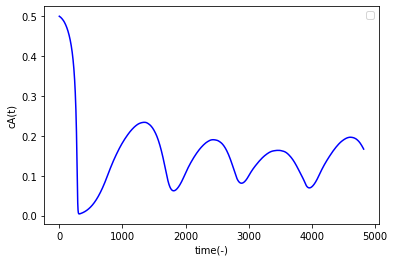

In [35]:
plt.plot(cA,'b-')
plt.xlabel('time(-)')
plt.ylabel('cA(t)')
plt.legend()

No handles with labels found to put in legend.


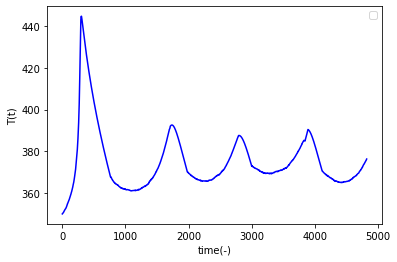

In [36]:
plt.plot(T,'b-')
plt.xlabel('time(-)')
plt.ylabel('T(t)')
plt.legend()

No handles with labels found to put in legend.


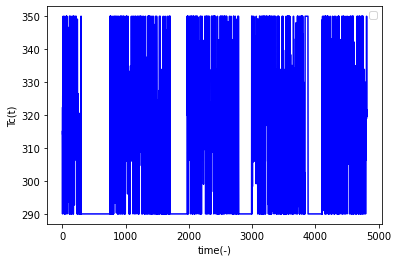

In [37]:
plt.plot(Tc_history,'b-')
plt.xlabel('time(-)')
plt.ylabel('Tc(t)')
plt.legend()

# Additional materials

[Field guide to GP --notes](https://digitalcommons.morris.umn.edu/cgi/viewcontent.cgi?article=1001&context=cs_facpubs)

